In [2]:
#导入必要依赖库
import torch.optim
import  torchvision
from torch.nn import Linear, Flatten, MaxPool2d, Conv2d
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch import  nn
from torch.utils.tensorboard import SummaryWriter
import os
import pandas as pd
from PIL import Image
import torch.nn.init as init
import matplotlib.pyplot as plt

In [4]:
# 文件夹准备
# 拼接模型保存路径
folder_path = "../models/DAN"

Train_data_path = '../RAF/images/train'
test_data_path = "../RAF/images/test"

if not os.path.exists(folder_path):
    os.makedirs(folder_path)  

In [5]:
# 查看图片模式和向量大小，方便数据初始化和确认通道数
img = Image.open("../RAF/images/all/0/test_0002_aligned.jpg")
tensor = torchvision.transforms.ToTensor()(img)
print("Tensor 形状：", tensor.shape) 
print("图像模式：", img.mode)

Tensor 形状： torch.Size([3, 100, 100])
图像模式： RGB


In [6]:
###准备数据集和测试集
###Tensor 形状： torch.Size([3, 100, 100]) 图像模式： RGB
transform = torchvision.transforms.Compose([
     torchvision.transforms.Resize((48,48)),          #统一尺寸
    torchvision.transforms.ToTensor(),                   # 转换为 [C, H, W] 的张量，范围 [0, 1]
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      std=[0.229, 0.224, 0.225])  
])
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((48, 48)),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),       # 水平翻转
    torchvision.transforms.RandomRotation(10),                # 旋转 ±10°
    torchvision.transforms.ColorJitter(brightness=0.1, contrast=0.1),  # 颜色抖动
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_data = torchvision.datasets.ImageFolder(root=Train_data_path, transform=train_transform)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True,drop_last=True)

test_data = torchvision.datasets.ImageFolder(root=test_data_path, transform=transform)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False,drop_last=True)

print("类别标签顺序：", train_data.classes)

类别标签顺序： ['0', '1', '2', '3', '4', '5', '6']


In [49]:


class DAN(nn.Module):
    def __init__(self, num_class=7,num_head=4, pretrained=True):
        super(DAN, self).__init__()
        
        resnet = torchvision.models.resnet18(pretrained=True)
        
       # if pretrained:
           # checkpoint = torch.load('./models/resnet18_msceleb.pth')
            #resnet.load_state_dict(checkpoint['state_dict'],strict=True)

        self.features = nn.Sequential(*list(resnet.children())[:-2])
        self.num_head = num_head
        for i in range(num_head):
            setattr(self,"cat_head%d" %i, CrossAttentionHead())
        self.sig = nn.Sigmoid()
        self.fc = nn.Linear(512, num_class)
        self.bn = nn.BatchNorm1d(num_class)


    def forward(self, x):
        x = self.features(x)
        heads = []
        for i in range(self.num_head):
            heads.append(getattr(self,"cat_head%d" %i)(x))
        
        heads = torch.stack(heads).permute([1,0,2])
        if heads.size(1)>1:
            heads = F.log_softmax(heads,dim=1)
            
        out = self.fc(heads.sum(dim=1))
        out = self.bn(out)
   
        return out, x, heads

class CrossAttentionHead(nn.Module):
    def __init__(self):
        super().__init__()
        self.sa = SpatialAttention()
        self.ca = ChannelAttention()
        self.init_weights()


    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.normal_(m.weight, std=0.001)
                if m.bias is not None:
                    init.constant_(m.bias, 0)
    def forward(self, x):
        sa = self.sa(x)
        ca = self.ca(sa)

        return ca


class SpatialAttention(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1x1 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=1),
            nn.BatchNorm2d(256),
        )
        self.conv_3x3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
        )
        self.conv_1x3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=(1,3),padding=(0,1)),
            nn.BatchNorm2d(512),
        )
        self.conv_3x1 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=(3,1),padding=(1,0)),
            nn.BatchNorm2d(512),
        )
        self.relu = nn.ReLU()


    def forward(self, x):
        y = self.conv1x1(x)
        y = self.relu(self.conv_3x3(y) + self.conv_1x3(y) + self.conv_3x1(y))
        y = y.sum(dim=1,keepdim=True) 
        out = x*y
        
        return out 

class ChannelAttention(nn.Module):

    def __init__(self):
        super().__init__()
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.attention = nn.Sequential(
            nn.Linear(512, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(inplace=True),
            nn.Linear(32, 512),
            nn.Sigmoid()    
        )


    def forward(self, sa):
        sa = self.gap(sa)
        sa = sa.view(sa.size(0),-1)
        y = self.attention(sa)
        out = sa * y
        
        return out

In [50]:
model = DAN(num_class=7, pretrained=True)
model.cuda()

loss_function = nn.CrossEntropyLoss(label_smoothing=0.1)
loss_function=loss_function.cuda()

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)


epoch = 25
accuracy = 0
best_acc = 0

accuracies=[]
losses = []

train_data_len = len(train_data)
test_data_len = len(test_data)
print("训练集的长度为{}".format(train_data_len))
print("测试集的长度为{}".format(test_data_len))

训练集的长度为12271
测试集的长度为3068


In [51]:
total_train_step = 0
torch.cuda.empty_cache()## 训练之前清理显存避免显存爆炸

for i in range(epoch):
    print("---------第{}轮训练开始---------".format(i+1))
    model.train()
    for data in train_loader:
        img,target = data
        img= img.cuda()
        target = target.cuda()
        output,x,heads = model(img)

        loss=loss_function(output,target)
        optimizer.zero_grad()

        loss.backward()
        optimizer.step()
        
        total_train_step+=1

        if total_train_step % 100==0:
            print("训练次数{}，Loss：{}".format(total_train_step,loss.item()))
    #测试步骤
    total_test_loss = 0
    total_accuracy = 0
    with torch.no_grad():
        model.eval()
        for data in test_loader :
            img,target = data
            img = img.cuda()
            target = target.cuda()
            output,x,heads = model(img)
            loss = loss_function(output,target)
            total_test_loss+=loss.item()
            accuracy = (output.argmax(1) == target ).sum().item()
            total_accuracy += accuracy
    print("正确率{}".format(total_accuracy/test_data_len))
    accuracies.append(total_accuracy/test_data_len)
    print("整体测试集上的Loss{}".format(total_test_loss))
    losses.append(total_test_loss)
    torch.save(model, os.path.join(folder_path, "module_{}.pth".format(i)))

---------第1轮训练开始---------
正确率0.6505867014341591
整体测试集上的Loss19.267359673976898
---------第2轮训练开始---------
训练次数100，Loss：1.1305121183395386
正确率0.6867666232073012
整体测试集上的Loss17.42693555355072
---------第3轮训练开始---------
正确率0.7121903520208605
整体测试集上的Loss16.25156807899475
---------第4轮训练开始---------
训练次数200，Loss：1.1029269695281982
正确率0.7304432855280313
整体测试集上的Loss16.134808778762817
---------第5轮训练开始---------
训练次数300，Loss：0.994805097579956
正确率0.7059973924380704
整体测试集上的Loss16.6474968791008
---------第6轮训练开始---------
正确率0.7128422425032594
整体测试集上的Loss15.8043172955513
---------第7轮训练开始---------
训练次数400，Loss：0.9327462911605835
正确率0.7464146023468058
整体测试集上的Loss15.060202598571777
---------第8轮训练开始---------
正确率0.7226205997392438
整体测试集上的Loss15.754637897014618
---------第9轮训练开始---------
训练次数500，Loss：0.8370749950408936
正确率0.7617340286831812
整体测试集上的Loss14.296559989452362
---------第10轮训练开始---------
训练次数600，Loss：0.7724254131317139
正确率0.7539113428943938
整体测试集上的Loss14.18201631307602
---------第11轮训练开始---------
正确率0.732

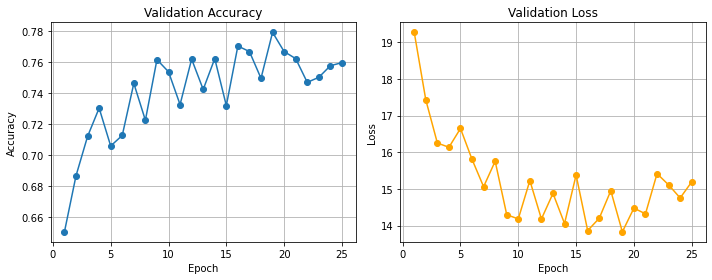

In [52]:
## 绘制损失函数图像

import matplotlib.pyplot as plt

epochs = list(range(1, len(accuracies)+1))

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, accuracies, label='Accuracy', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, losses, label='Test Loss', color='orange', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Validation Loss")
plt.grid(True)

plt.tight_layout()
plt.show()


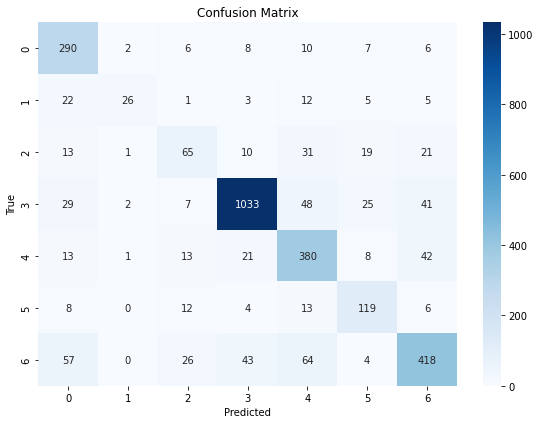

In [53]:
## 绘制confusion matirx
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import numpy as np

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for img, target in test_loader:
        img = img.cuda()
        target = target.cuda()
        output,x,heads = model(img)
        preds = output.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(target.cpu().numpy())

# 生成混淆矩阵
cm = confusion_matrix(all_labels, all_preds)
labels = train_data.classes  # 类别名称

# 可视化
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()
